In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Input, Activation, Dense, Dropout, LSTM, Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import os
%matplotlib inline

In [32]:
path_data = os.path.join(os.getcwd(),"data")

coin_dataframes = {}

def convert_comma_int(field):
    try:
        return int(field.replace(',', ''))
    except ValueError:
        return None
    
for fn in os.listdir(path_data):
    #if "bitcoin_cache" in fn:
     #   continue
    if fn.startswith("coin_"):
        coin_name = fn.split("_")[1].split(".")[0]
        df = pd.read_csv(os.path.join(path_data, fn), parse_dates=["Date"])
        #df['Marketcap'] = df['Marketcap'].map(convert_comma_int)
        coin_dataframes[coin_name] = df.sort_values('Date')

In [33]:
coin_dataframes.keys()

dict_keys(['Aave', 'BinanceCoin', 'Bitcoin', 'Cardano', 'ChainLink', 'Cosmos', 'CryptocomCoin', 'Dogecoin', 'EOS', 'Ethereum', 'Iota', 'Litecoin', 'Monero', 'NEM', 'Polkadot', 'Solana', 'Stellar', 'Tether', 'Tron', 'Uniswap', 'USDCoin', 'WrappedBitcoin', 'XRP'])

In [34]:
coin_dataframes['BinanceCoin'].head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Binance Coin,BNB,2017-07-26 23:59:59,0.109013,0.099266,0.105893,0.105138,200395.0,10513800.0
1,2,Binance Coin,BNB,2017-07-27 23:59:59,0.108479,0.100888,0.105108,0.107737,344499.0,10773700.0
2,3,Binance Coin,BNB,2017-07-28 23:59:59,0.109019,0.101473,0.107632,0.104067,342568.0,10406700.0
3,4,Binance Coin,BNB,2017-07-29 23:59:59,0.111264,0.101108,0.104782,0.107811,340218.0,10781100.0
4,5,Binance Coin,BNB,2017-07-30 23:59:59,0.108138,0.103162,0.107935,0.106414,224261.0,10641400.0


# Compute relative growth and other relative values

We add these values as new columns to the dataframes:

In [6]:
def add_relative_columns(df):
    day_diff = df['Close'] - df['Open']
    df['rel_close'] = day_diff / df['Open']
    df['high_low_ratio'] = df['High'] / df['Low']
    df['rel_high'] = df['High'] / df['Close']
    df['rel_low'] = df['Low'] / df['Close']
    
    
for df in coin_dataframes.values():
    add_relative_columns(df)


## Create historical training data

The history tables will have values for the last 10 days for each day.

In [41]:
df = coin_dataframes['Ethereum'].copy()
df.drop(columns=['SNo','Name','Symbol'],inplace=True)
df['Date'] = df['Date'].dt.date
df.set_index("Date",inplace=True)

target_col = 'Close'

In [42]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(df, test_size=0.2)

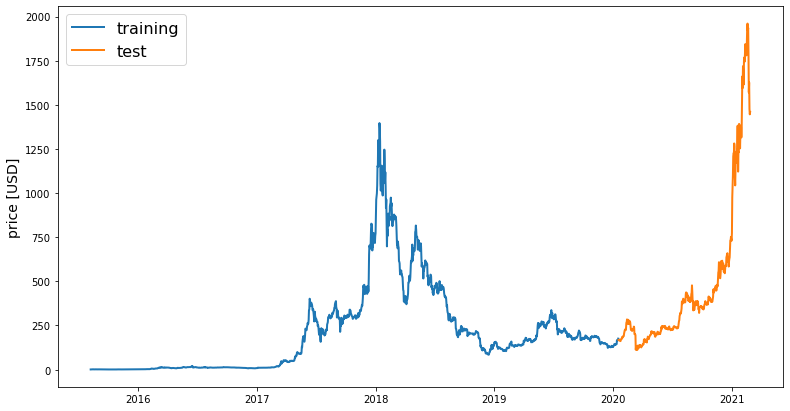

In [43]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

### Normalize data

In [44]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [45]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [46]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

### LSTM model

In [47]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [48]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [50]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
51/51 [==============================] - 2s 2ms/step - loss: 0.0194
Epoch 2/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 3/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 4/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 5/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 6/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 7/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 8/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 9/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 10/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 11/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 12/20
51/51 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 13/20
51/51 [==============================

In [69]:
X_test.shape

(401, 5, 6)

In [65]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.038006353073393194

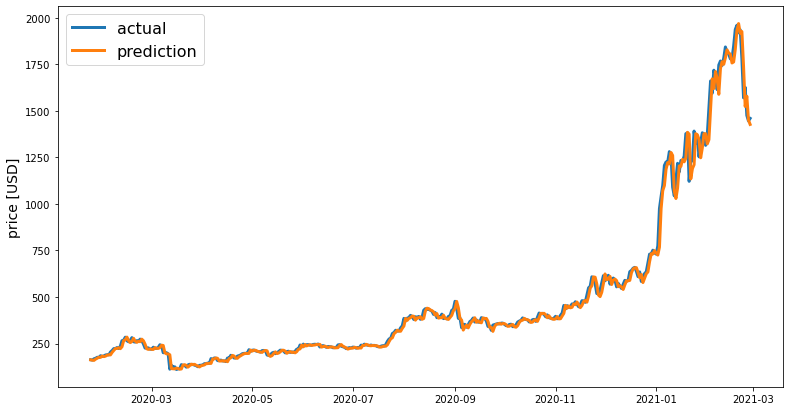

In [67]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)